## Machine Learning for Humanists Day 2: Case Study
## Identifying Jim Crow Laws*

## Getting Started



----
## Importing Libraries


In [1]:
# Library for Importing CSV file into a Dataframe
import pandas as pd
# Library to split the data into train and test sets
from sklearn.model_selection import train_test_split
# Libraries to process section_text Tokenize=find words, Stopwords=remove stopwords, Regular Expression=remove non-word characters, Lemmatize text
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
# A transformer LengthExtractor to extract length of each sentences in the section_text
from sklearn.base import BaseEstimator, TransformerMixin

# Machine Learning Libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

#Model Tuning Libraries
from sklearn.model_selection import GridSearchCV

#Evaluation Libraries
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Allows the use of display() for DataFrames
from IPython.display import display
# Pretty display for notebooks
%matplotlib inline

#Ignore warnings = clean notebook
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# nltk.download('stopwords')
# nltk.download('punkt')

----
## Exploring the Data


In [6]:
data = pd.read_csv('training_set_clean.csv')

In [7]:
data.head()

,index,reviewer,sample,James_Assessment,Explicit_Implicit_Extrinsic,type,sess,chapter_text,section_text
0,277:2,paschal,pre-existing,1,1.0,public laws,1879,CHAPTER 276 AN ACT TO AUTHORIZE THE BOARD OF E...,That the board of education of the counties of...
1,28:4,paschal,pre-existing,1,1.0,public laws,1880,CHAPTER 27 AN ACT TO AUTHORIZE THE ESTABLISHME...,The special taxes thus levied and collected fr...
2,28:9,paschal,pre-existing,1,1.0,public laws,1880,CHAPTER 27 AN ACT TO AUTHORIZE THE ESTABLISHME...,The board of commissioners for the county of W...
3,201:23,paschal,pre-existing,1,1.0,public laws,1881,CHAPTER 200 AN ACT TO REVISE AND CONSOLIDATE T...,The county board of education of every county ...
4,201:33,paschal,pre-existing,1,1.0,public laws,1881,CHAPTER 200 AN ACT TO REVISE AND CONSOLIDATE T...,The county treasurer of each county shall repo...


Before the file was imported, we performed simple preprocessing on the text (these are outlined in the code bellow):
* Replaced hyphenated and line broken words with unbroken words.
* Removed section numbering from the law text ("section_text").
* We used session or volume identified ("csv") information to extract a numeric year.  In the case of multi-year volumes (e.g. 1956-1957) the earlier year was used.

In [8]:
#Fix hyphenated words
#data["chapter_text"] = data.text.str.replace(r"-[ \|]+(?P<letter>[a-zA-Z])",repl).astype("str")
#data["section_text"] = data.section_text.str.replace(r"-[ \|]+(?P<letter>[a-zA-Z])",repl).astype("str")
#data["section_text"] = [re.sub(r'- *\n+(\w+ *)', r'\1\n',r) for r in data["section_text"]]
#Remove section titles (e.g. "Sec. 1") from law text.
#data["start"] = data.section_raw.str.len().fillna(0).astype("int")
#data["section_text"] = data.apply(lambda x: x['section_text'][(x["start"]):], axis=1).str.strip()

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1824 entries, 0 to 1823
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   index                        1824 non-null   object 
 1   reviewer                     1824 non-null   object 
 2   sample                       1824 non-null   object 
 3   James_Assessment             1824 non-null   int64  
 4   Explicit_Implicit_Extrinsic  1816 non-null   float64
 5   type                         1824 non-null   object 
 6   sess                         1824 non-null   object 
 7   chapter_text                 1824 non-null   object 
 8   section_text                 1824 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 128.4+ KB


### Data Exploration


In [10]:
data['James_Assessment'] = data['James_Assessment'].astype(np.int64)

In [11]:
data['James_Assessment'].value_counts()

0    1235
1     589
Name: James_Assessment, dtype: int64

In [12]:
# Total number of records
n_records = len(data.index)

# jim crow laws
jim_crow_laws = len(data[data.James_Assessment == 1])

# non-jim crow laws
regular_laws = len(data[data.James_Assessment == 0])

# Percent of Jim Crow Laws
jimcrow_percent = (jim_crow_laws / float(n_records)) * 100

# Print the results
print("Total number of records: {}".format(n_records))
print("Jim Crow Laws: {}".format(jim_crow_laws))
print("Non-Jim Crow Laws: {}".format(regular_laws))
print("Percentage of Jim Crow Laws: {}%".format(jimcrow_percent))

Total number of records: 1824
Jim Crow Laws: 589
Non-Jim Crow Laws: 1235
Percentage of Jim Crow Laws: 32.29166666666667%


----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

In [13]:
# Split the data into features and target label
features = dataframe['section_text']
target = dataframe['James_Assessment']

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [14]:
# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 1459 samples.
Testing set has 365 samples.


### Data Preprocessing



In [15]:
#Text Processing
# extract the english stopwords and save it to a variable
stopword = stopwords.words('english')
# define regular expression to identify non-ascii characters in text
non_ascii_regex = r'[^\x00-\x7F]+'
def tokenize(text):
        
    # use library re to replace non ascii characters by a space
    text = re.sub(non_ascii_regex, ' ', text)  

    # use word_tokenize to tokenize the sentences
    tokens = word_tokenize(text)
    
    # instantiate an object of class WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()

    # use a list comprehension to lemmatize the tokens and remove the the stopwords
    clean_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopword]

    # return the tokens
    return clean_tokens

### Transformer of text = turning text into numbers

In [17]:
# A transformer LengthExtractor to extract length of each sentences in the section_text and make that a feature
class LengthExtractor(BaseEstimator, TransformerMixin):
    
    def compute_length(self, text):
        sentence_list = word_tokenize(text)
        return len(sentence_list)
    
    def fit(self, x, y=None):
        return self

    def transform(self, X):
        X_length = pd.Series(X).apply(self.compute_length)
        return pd.DataFrame(X_length)

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
# list of text documents
text = ["The quick brown fox jumped over the lazy dog."]
# create the transform
vectorizer = CountVectorizer()
# tokenize and build vocab
vectorizer.fit(text)
# summarize
print(vectorizer.vocabulary_)
# encode document
vector = vectorizer.transform(text)
# summarize encoded vector
print(vector.shape)
print(type(vector))
print(vector.toarray())

{'the': 7, 'quick': 6, 'brown': 0, 'fox': 2, 'jumped': 3, 'over': 5, 'lazy': 4, 'dog': 1}
(1, 8)
<class 'scipy.sparse.csr.csr_matrix'>
[[1 1 1 1 1 1 1 2]]


We can see that there are 8 words in the vocab, and therefore encoded vectors have a length of 8.

We can then see that the encoded vector is a sparse matrix. Finally, we can see an array version of the encoded vector showing a count of 1 occurrence for each word except the (index and id 7) that has an occurrence of 2

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
# list of text documents
text = ["The quick brown fox jumped over the lazy dog.", "The dog.", "The fox"]
# create the transform
vectorizer = TfidfVectorizer()
# tokenize and build vocab
vectorizer.fit(text)
# summarize
print(vectorizer.vocabulary_)
print(vectorizer.idf_)
# encode document
vector = vectorizer.transform([text[0]])
# summarize encoded vector
print(vector.shape)
print(vector.toarray())

{'the': 7, 'quick': 6, 'brown': 0, 'fox': 2, 'jumped': 3, 'over': 5, 'lazy': 4, 'dog': 1}
[1.69314718 1.28768207 1.28768207 1.69314718 1.69314718 1.69314718
 1.69314718 1.        ]
(1, 8)
[[0.36388646 0.27674503 0.27674503 0.36388646 0.36388646 0.36388646
  0.36388646 0.42983441]]


A vocabulary of 8 words is learned from the documents and each word is assigned a unique integer index in the output vector.

The inverse document frequencies are calculated for each word in the vocabulary, assigning the lowest score of 1.0 to the most frequently observed word: “the” at index 7.

Finally, the first document is encoded as an 8-element sparse array

----
## Training our Model

### Creating a Training and Predicting Pipeline

In [18]:
# create an instance of Pipeline class
pipeline = Pipeline([
    
        # create a FeatureUnion pipeline
        ('features', FeatureUnion([

            # add a pipeline element to extract features using CountVectorizer and TfidfTransformer
            ('text_pipleline', Pipeline([
                ('vect', CountVectorizer(decode_error = "ignore",
                      min_df = 2, max_df = 1000)),
                ('tfidf', TfidfTransformer()),
            ])),
            
            # add the pipeline element - LengthExtractor to extract lenght of each sentence as feature
            ('text_len', LengthExtractor()),
        ])),

        # use the predictor estimator RandomForestClassifier to train the model
        ('dlf', RandomForestClassifier())
])

Random forest, like its name implies, consists of a large number of individual decision trees that operate as an ensemble. Each individual tree in the random forest spits out a class prediction and the class with the most votes becomes our model’s prediction

https://towardsdatascience.com/understanding-random-forest-58381e0602d2

In [19]:
#Run the Model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('text_pipleline',
                                                 Pipeline(steps=[('vect',
                                                                  CountVectorizer(decode_error='ignore',
                                                                                  max_df=1000,
                                                                                  min_df=2)),
                                                                 ('tfidf',
                                                                  TfidfTransformer())])),
                                                ('text_len',
                                                 LengthExtractor())])),
                ('dlf', RandomForestClassifier())])

###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Naive Predictor Performace
* If we chose a model that always predicted if a law was jim crow, what would  that model's accuracy and F-score be on this dataset?

** Please note ** that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.

** NOTE: ** 

* When we have a model that always predicts '1' (i.e. there is always a jim crow law) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [16]:
#Calculate Accuracy, Recall, Precision
accuracy = (np.sum(target)) / ((np.sum(target)) + float(((target.count()) - np.sum(target))))
recall = np.sum(target) / float((np.sum(target) + 0))
precision = np.sum(target) / float(((np.sum(target) + ((target.count()) - np.sum(target)))))

#Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
beta = 0.5
fscore = (1+ beta**2) * (precision * recall) / ((beta ** 2 * precision) + recall)

#Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.3229, F-score: 0.3735]


### Initial Model Evaluation

#### What is accuracy, precision, recall?

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as Jim Crow, actually were Jim Crow.
It is a ratio of true positives(laws classified as Jim Crow, and which are actually Jim Crow) to all positives(all laws classified as Jim Crow, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of laws that actually were Jim Crow were classified by us as Jim Crow.
It is a ratio of true positives(laws classified as Jim Crow, and which are actually Jim Crow) to all the laws that were actually Crow, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios). We can use **F-beta score** as a metric that considers both precision and recall:


$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Another Resource for understanding this report: https://medium.com/@kohlishivam5522/understanding-a-classification-report-for-your-machine-learning-model-88815e2ce397


In [20]:
#Make Predictions on the Test Data
y_pred = pipeline.predict(X_test)

[Text(0.5, 1.0, 'Overall')]

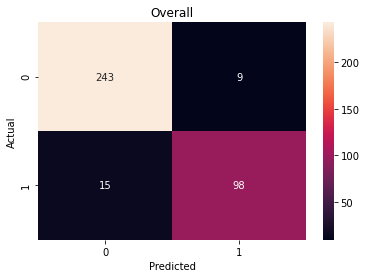

In [21]:
# count the number of labels
labels = np.unique(y_pred)

data = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

# use sns.heatmap on top of confusion_matrix to show the confusion matrix
ax = sns.heatmap(df_cm,xticklabels=True, annot=True, fmt='.0f')
ax.set(title="Overall")

True Negative = 243
False Positive = 9
False Negative = 15
True Postive = 98

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       252
           1       0.92      0.87      0.89       113

    accuracy                           0.93       365
   macro avg       0.93      0.92      0.92       365
weighted avg       0.93      0.93      0.93       365

